Prophet Paper - https://peerj.com/preprints/3190/

In [ ]:
#Instala Prophet
#!pip install fbprophet

In [ ]:
#Carga el paquete para modelar series de tiempo
from fbprophet import Prophet
import fbprophet
fbprophet.__version__


'0.7.1'

In [ ]:
#Carga paquetes generales
import numpy as np
import pandas as pd
from datetime import datetime
import itertools

# visual libraries
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import plotly.express as px
import os
from mpl_toolkits.mplot3d import Axes3D 
plt.style.use('ggplot')
from seaborn import kdeplot





# modelado
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.serialize import model_to_json, model_from_json
from fbprophet.plot import plot_cross_validation_metric


# sklearn libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef,classification_report,roc_curve
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

# distribution of anomalous features
from sklearn.preprocessing import StandardScaler

# manejo de archivos
import json


# pruebas estadisticas de estacionalidad y causalidad
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import boxcox
from scipy.special import inv_boxcox

#mpl.rcParams['figure.figsize'] = (10, 8)
#mpl.rcParams['axes.grid'] = False


In [ ]:
#Carga Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Define la ruta raiz del proyecto
ruta="/content/drive/MyDrive/AIre/BD/"

In [ ]:
#Carga datos de una estación
estac='XAL'
df=pd.read_csv(ruta + estac +'2_2015_2020.csv')
df.date2=pd.to_datetime(df['date2'],format="%Y-%m-%d %H:%M:%S")
df=df.set_index('date2')
df.drop(columns=['WDR'],inplace=True,axis=1)      #en este modelo no se va a analizar WDR, para incluirla se requiere hacer la conversión de WSP-WDR a X-Y (de coordenadas polares a cartesianas)
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41285 entries, 2015-01-01 00:00:00 to 2019-09-30 00:00:00
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        41285 non-null  object 
 1   Date        41285 non-null  object 
 2   Hour        41285 non-null  int64  
 3   year        41285 non-null  int64  
 4   id_station  41285 non-null  object 
 5   CO          37197 non-null  float64
 6   NO          37109 non-null  float64
 7   NO2         37109 non-null  float64
 8   NOX         37109 non-null  float64
 9   O3          37488 non-null  float64
 10  PA          37926 non-null  float64
 11  PM10        34975 non-null  float64
 12  PM2.5       34975 non-null  float64
 13  PMCO        34975 non-null  float64
 14  RH          37946 non-null  float64
 15  SO2         37608 non-null  float64
 16  TMP         37939 non-null  float64
 17  WSP         38004 non-null  float64
 18  Month       41285 non-null  int

In [ ]:
#Un vistazo al inicio de la base de datos
df.head(2)

date        Date  Hour  ...   TMP  WSP  Month
date2                                                    ...                  
2015-01-01 00:00:00  01/01/2015 01:00  01/01/2015     0  ...  13.1  0.6      1
2015-01-01 01:00:00  01/01/2015 02:00  01/01/2015     1  ...  12.4  0.4      1

[2 rows x 19 columns]

In [ ]:
#Un vistazo al final de la base de datos
df.tail(2)

date        Date  Hour  ...   TMP  WSP  Month
date2                                                    ...                  
2019-09-29 23:00:00  29/09/2019 24:00  29/09/2019    23  ...  14.6  6.0      9
2019-09-30 00:00:00  30/09/2019 01:00  30/09/2019     0  ...  14.3  6.9      9

[2 rows x 19 columns]

In [ ]:
#Total de datos faltantes por variable (registros horarios)
df.isnull().sum()

date             0
Date             0
Hour             0
year             0
id_station       0
CO            4088
NO            4176
NO2           4176
NOX           4176
O3            3797
PA            3359
PM10          6310
PM2.5         6310
PMCO          6310
RH            3339
SO2           3677
TMP           3346
WSP           3281
Month            0
dtype: int64

In [ ]:
#Función para realizar una gráfica interactiva del comportamiento de una variable
def graf_iter(df,fecha,var,est,reg="H"):
  df=df.reset_index()
  if reg=="H":
    prom="horaria"
  else:
    prom="diaria"

  fig = px.line(df, x=fecha, y=var, title='Concentración '+ prom +' de ' + var +' en ' + est)

  fig.update_xaxes(
      rangeslider_visible=True,
      rangeselector=dict(
          buttons=list([
              dict(count=1, label="1y", step="year", stepmode="backward"),
              dict(count=2, label="3y", step="year", stepmode="backward"),
              dict(count=3, label="5y", step="year", stepmode="backward"),
              dict(step="all")
          ])
      )
  )
  fig.show()

In [ ]:
#Un vistazo al comportamiento de la variables a pronosticar, PM2.5 (registros horarios)
graf_iter(df,'date2','PM2.5',estac)

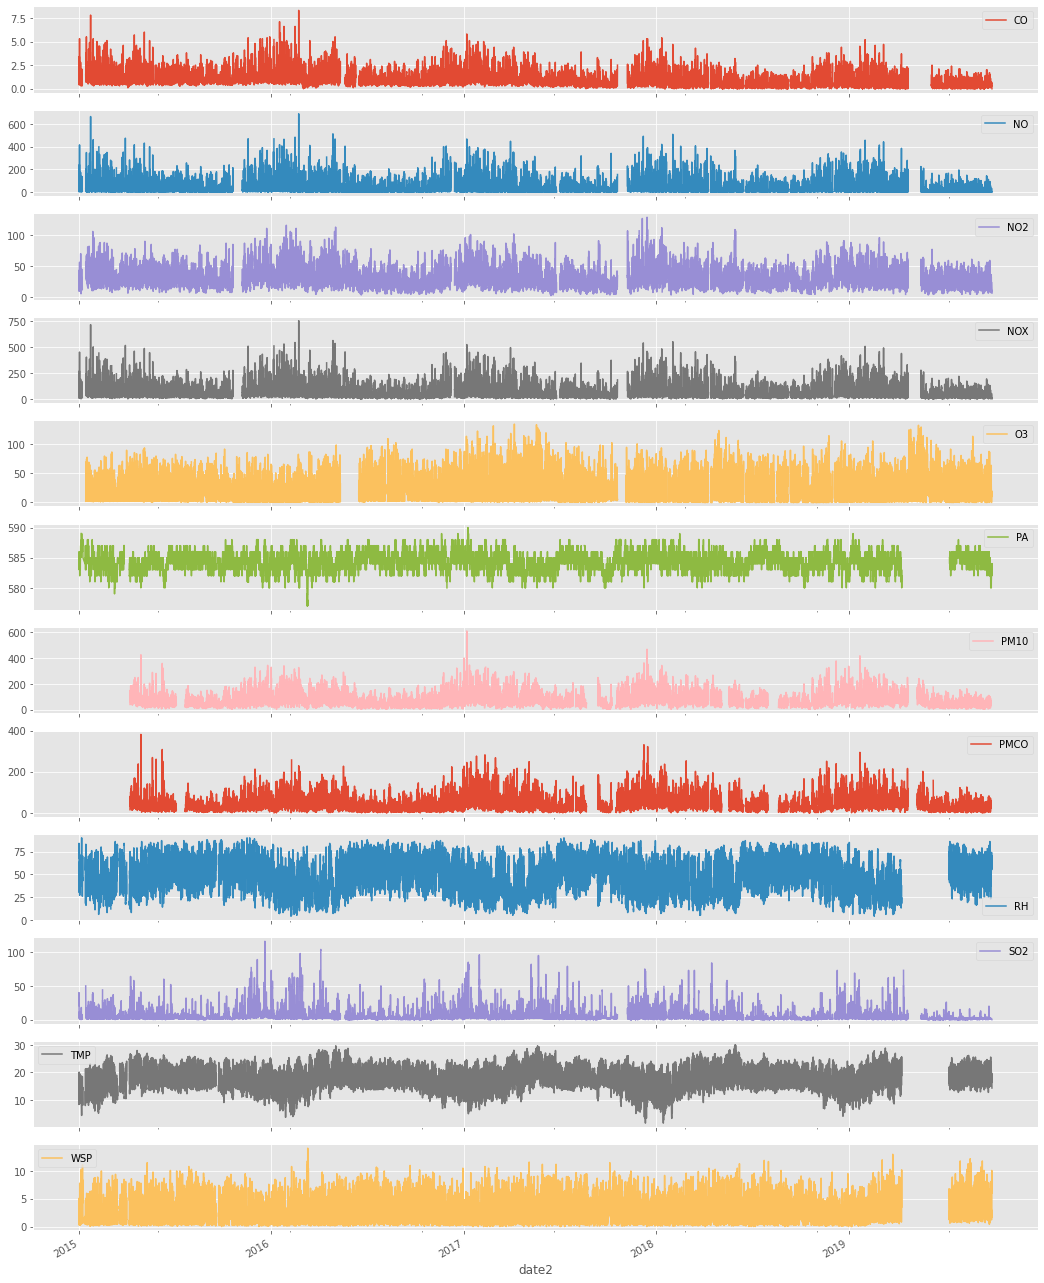

In [ ]:
#visualización registros horarios de las covaribles o variables regresoras
df[df.columns[~df.columns.isin(['date','Date','Hour','year','id_station','PM2.5','Month'])]].plot(subplots=True, figsize=(18,25))
plt.show()

In [ ]:
#Promedio diario
df_d=df[df.columns[~df.columns.isin(['date','Date','Hour','year','id_station','Month'])]].resample('D').mean()

#elimina las variables que no cuentan con al menos el 50% de datos diarios en el periodo
df_d=df_d[df_d.columns[df_d.count()>df_d.shape[0]*0.5]]
df_d

CO         NO        NO2  ...        SO2        TMP       WSP
date2                                       ...                                
2015-01-01  1.637500  58.208333  25.541667  ...  14.750000  14.441667  1.720833
2015-01-02  1.641667  90.291667  30.541667  ...   4.125000  14.708333  2.716667
2015-01-03  1.025000  44.666667  27.291667  ...   2.500000  14.627273  1.922727
2015-01-04  1.200000  51.363636  23.772727  ...   2.818182  13.262500  3.862500
2015-01-05  0.604167  18.750000  18.333333  ...   4.375000  10.940000  3.726667
...              ...        ...        ...  ...        ...        ...       ...
2019-09-26  0.575000  19.916667  28.541667  ...   1.333333  18.683333  3.500000
2019-09-27  0.358333  13.217391  21.000000  ...   1.086957  18.945833  3.612500
2019-09-28  0.347619   9.666667  21.714286  ...   1.050000  18.787500  3.620833
2019-09-29  0.329167  10.541667  15.083333  ...   0.791667  17.025000  4.958333
2019-09-30  0.000000   1.000000   6.000000  ...   0.000000  14.300000  6.900000

[1734 rows x 13 columns]

In [ ]:
#Correlacion
df_d.corr("spearman")

PM2.5        CO        NO  ...       SO2       TMP       WSP
PM2.5  1.000000  0.663301  0.622644  ...  0.706144 -0.053391 -0.596336
CO     0.663301  1.000000  0.756500  ...  0.570403 -0.136292 -0.560728
NO     0.622644  0.756500  1.000000  ...  0.528526 -0.176134 -0.470272
NO2    0.843717  0.748465  0.726133  ...  0.583583 -0.051016 -0.641585
NOX    0.744037  0.804748  0.967980  ...  0.584392 -0.141755 -0.559725
O3     0.107246 -0.176151 -0.304848  ... -0.049267  0.432256  0.079745
PA    -0.137713 -0.147310 -0.120147  ... -0.050112 -0.279034  0.049184
PM10   0.901711  0.599434  0.707466  ...  0.682381 -0.012642 -0.446858
PMCO   0.735202  0.490773  0.690192  ...  0.589467  0.014998 -0.301173
RH    -0.323666 -0.200624 -0.349257  ... -0.327419 -0.244734 -0.022753
SO2    0.706144  0.570403  0.528526  ...  1.000000 -0.115695 -0.437142
TMP   -0.053391 -0.136292 -0.176134  ... -0.115695  1.000000  0.264283
WSP   -0.596336 -0.560728 -0.470272  ... -0.437142  0.264283  1.000000

[13 rows x 13 columns]

In [ ]:
#Faltantes diarios
df_d.isnull().sum()

CO       120
NO       114
NO2      114
NOX      114
O3       104
PA       116
PM10     228
PM2.5    228
PMCO     228
RH       110
SO2       96
TMP      110
WSP      110
dtype: int64

In [ ]:
#Un vistazo al comportamiento de la variables a pronosticar, PM2.5 (registros diarios)
#se detectan algunos datos extremos

df_d_ex=pd.DataFrame(np.exp(df_d['PM2.5']),index=df_d.index)
df_d_ex=df_d_ex.reset_index()
graf_iter(df_d_ex,'date2','PM2.5',estac,"D")

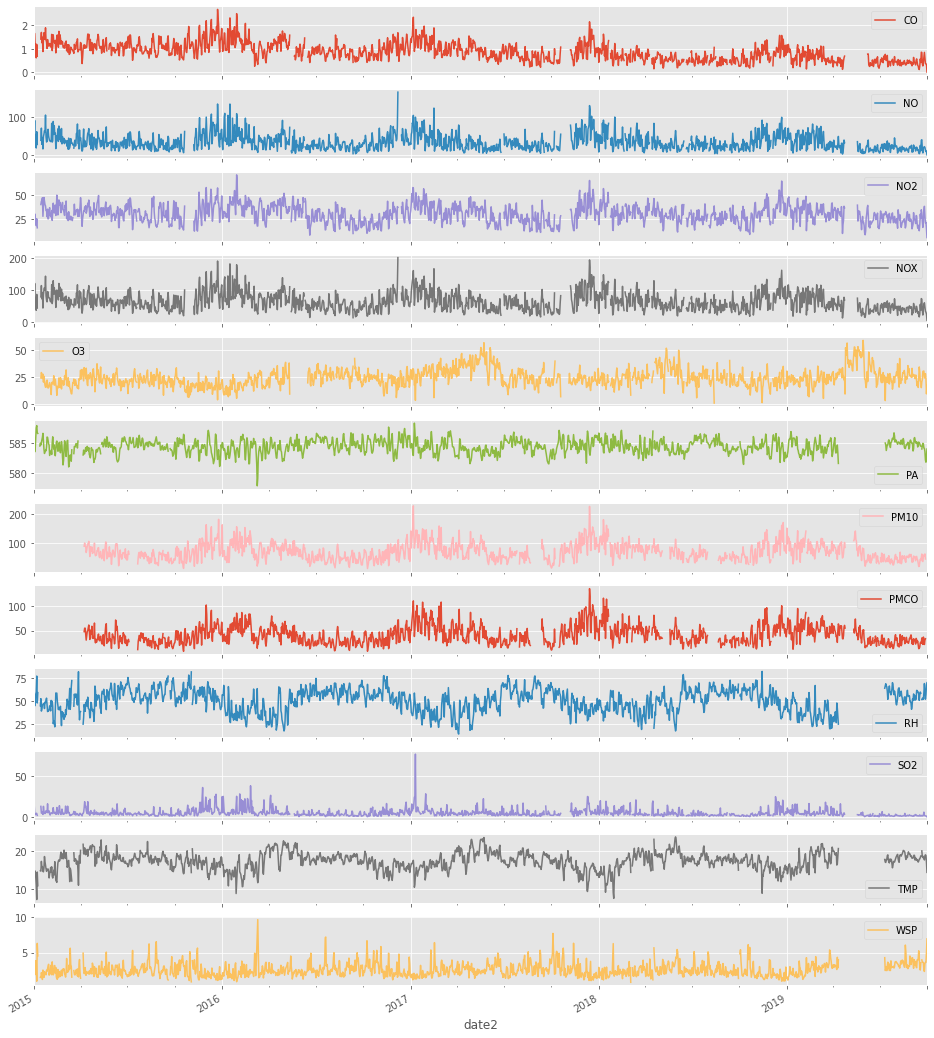

In [ ]:
#visualización registros diarios de las covaribles o variables regresoras
df_d[df_d.columns[~df_d.columns.isin(['PM2.5'])]].plot(subplots=True, figsize=(16,20))
plt.show()

#Modelación de PM2.5

Se usarán modelos aditivos


y(t)= g(t) + s(t) + h(t) + εt

donde:

y(t) es la variable a pronosticar

g(t) es la función de tendencia que modela cambios no periódicos usando un modelo de crecimiento de saturación no lineal o un modelo de regresión lineal por partes. Puede configurar esto usando parámetros.

s(t) es el funcional estacional (anual, semanal y diario) que modela los cambios periódicos en el valor de la serie temporal. Este componente se modela mediante una transformada de Fourier y, si lo desea, puede agregar sus propias estacionalidades.

h(t) representa la función para modelar días festivos y eventos de impacto especial. Puede agregar su propio conjunto de feriados personalizados y eventos especiales.

εt es el error / ruido de los modelos que se supone que tiene una distribución normal

https://futurice.com/blog/business-forecasting-with-facebook-prophet

In [ ]:
#reordena la base de datos para tener la variable de interés al incio
orden=df_d.columns
x=pd.DataFrame(df_d[['PM2.5']])
y=pd.DataFrame(df_d[orden[~orden.isin(['PM2.5'])]])
df_d=pd.concat([x,y],axis=1)
print(df_d.shape)
print(df_d.head(2))
print(df_d.tail(2))
del x
del y

(1734, 13)
            PM2.5        CO         NO  ...     SO2        TMP       WSP
date2                                   ...                             
2015-01-01    NaN  1.637500  58.208333  ...  14.750  14.441667  1.720833
2015-01-02    NaN  1.641667  90.291667  ...   4.125  14.708333  2.716667

[2 rows x 13 columns]
            PM2.5        CO         NO  ...       SO2     TMP       WSP
date2                                   ...                            
2019-09-29    NaN  0.329167  10.541667  ...  0.791667  17.025  4.958333
2019-09-30    NaN  0.000000   1.000000  ...  0.000000  14.300  6.900000

[2 rows x 13 columns]


In [ ]:
#parametros a usar en la modelación
param=df_d.columns
param

Index(['PM2.5', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PA', 'PM10', 'PMCO', 'RH',
       'SO2', 'TMP', 'WSP'],
      dtype='object')

Densidad de datos horarios de PM2.5


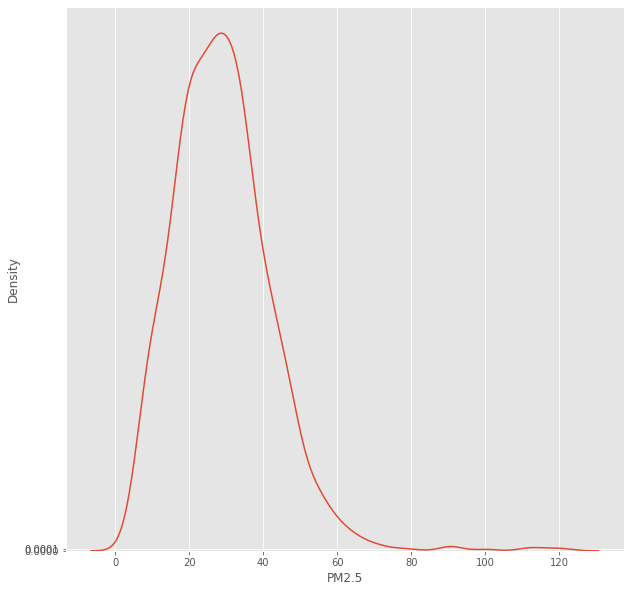

In [ ]:
#Densidad de PM2.5
plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(28, 1)

print("Densidad de datos horarios de PM2.5")
sns.kdeplot(data=df_d, x="PM2.5",gridsize=200)
plt.yticks([0, 0.0001])
    
plt.show()

In [ ]:
#tranformación de y
# Se pueed hacer via Box-Cox
# df_d['PM2.5'], lam = boxcox(df_d['PM2.5'])
# print('Lambda is:', lam)
# pero por la naturaleza de PM2.5 se optó por logaritmo

df_d['PM2.5']=np.log(df_d['PM2.5'])
df_d['PM2.5']


date2
2015-01-01         NaN
2015-01-02         NaN
2015-01-03         NaN
2015-01-04         NaN
2015-01-05         NaN
                ...   
2019-09-26    3.477387
2019-09-27    2.476938
2019-09-28         NaN
2019-09-29         NaN
2019-09-30         NaN
Freq: D, Name: PM2.5, Length: 1734, dtype: float64

In [ ]:
#Un vistazo al comportamiento de la variables tranformada
#se confirman los datos extremos los cuales se dejan debido a que están asociados a días festivos repetitivos
#se eliminan: 25/12/2015, 1/01/2016, 14/02/2016, 25/12/2018, 1/01/2019, 12/05/2019, 13/05/2019
graf_iter(df_d,'date2','PM2.5',estac+" (transformada logaritmo)","D")


Densidad de logaritmo de PM2.5


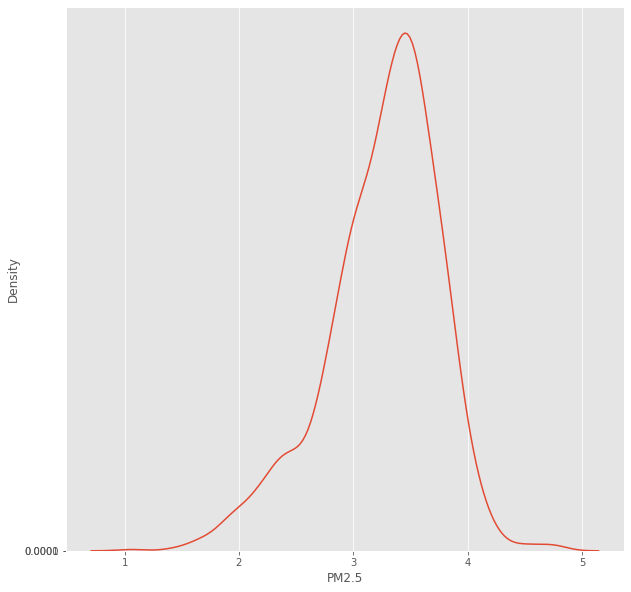

In [ ]:
#Densidad de log(PM2.5)
plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(28, 1)

print("Densidad de logaritmo de PM2.5")
sns.kdeplot(data=df_d, x="PM2.5",gridsize=200)
plt.yticks([0, 0.0001])
    
plt.show()

In [ ]:
#Creación de la estructura del modelo incluyendo los regresores sin faltantes
#tomar en cuenta que el relleno de faltantes en los regresores deben mantener el mismo rango de los datos originales
#y se mantienen los valores originales de los regresores y sólo se agregan los rellenos en los faltantes
#Define el periodo de aprendizaje y el de prueba (cuatro años-un año)
pronostico="31/01/2021" #equivale a periods=762 
for p in param:
  df_modelo=df_d.reset_index()[['date2',p]].rename({'date2':'ds',p:'y'}, axis='columns') #estructura 'ds','y'
  train=df_modelo[(df_modelo['ds'] >= '2015-01-01') & (df_modelo['ds'] <= '2018-12-31')]
  test=df_modelo[(df_modelo['ds'] > '2018-12-31') ]
  m=Prophet(interval_width=0.95,yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=False)
  m.add_country_holidays(country_name='MX')
  m.fit(train)
  future=m.make_future_dataframe(periods=762) #Hasta el primer mes de 2021 (2021/01/31)
  forecast=m.predict(future)
 
  if p=='PM2.5':
    forecast['y']=df_modelo['y'] #emplea la variable original de PM2.5 (con faltantes) OJO traen diferente tamaño
    DF = pd.DataFrame(forecast[['ds','y']])
  else:
    yforc = pd.DataFrame(forecast[['ds','yhat']])
    yforc[p]=df_modelo['y']
    yforc['relleno']=yforc[p]                                                   #conserva originales
    yforc.loc[yforc[p].isnull(),'relleno']=yforc.loc[yforc[p].isnull(),'yhat']  #reemplaza faltantes con el pronóstico
    yforc.loc[yforc['relleno']<yforc[p].min(),'relleno']=yforc[p].min()         #corrige limite inferior del pronóstico
    yforc.loc[yforc['relleno']>yforc[p].max(),'relleno']=yforc[p].max()         #corrige limite superior del pronóstico
    #limites=yforc.describe()
    # for estad in limites.index[1:]:                                           #corrobora que los datos se mantengan en los rangos originales
    #   if limites.loc[estad,p]<limites.loc[estad,'relleno']:
    #     print("Revisa el relleno de {}, cambios en {}".format(p,estad))
    #     print("describe: ",limites.loc[estad,:])

    yforc.drop(columns=[p,'yhat'],inplace=True)
    yforc=yforc.rename(columns={'relleno': p})        

    DF=pd.merge(DF, yforc, 'inner', on='ds', indicator='union') 
    DF.drop(columns=['union'],inplace=True,axis=1)

#Construye la matriz de regresores sin faltantes
DF0_o=DF.copy()
DF0_o.drop(columns=['y'],inplace=True,axis=1)

print("Estructura de la base con 'y'")
print(DF.tail(3))
print("")
print("Estructura de la base de los regresores")
print(DF0_o.tail(3))


Estructura de la base con 'y'
             ds   y        CO  ...       SO2        TMP       WSP
2220 2021-01-29 NaN  0.780742  ...  5.017111  13.683349  1.444861
2221 2021-01-30 NaN  0.699323  ...  4.760460  13.785179  1.348803
2222 2021-01-31 NaN  0.606572  ...  4.799400  13.915952  1.252305

[3 rows x 14 columns]

Estructura de la base de los regresores
             ds        CO         NO  ...       SO2        TMP       WSP
2220 2021-01-29  0.780742  53.967108  ...  5.017111  13.683349  1.444861
2221 2021-01-30  0.699323  48.139061  ...  4.760460  13.785179  1.348803
2222 2021-01-31  0.606572  36.349189  ...  4.799400  13.915952  1.252305

[3 rows x 13 columns]


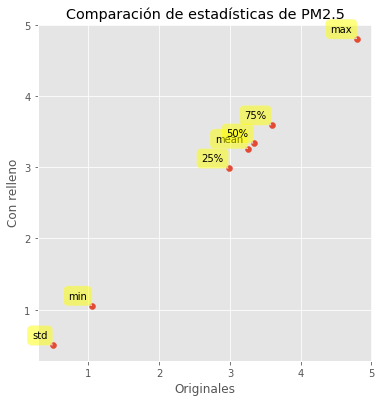

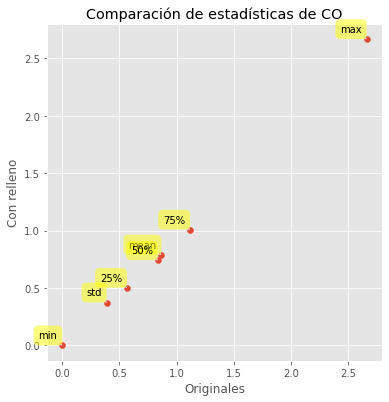

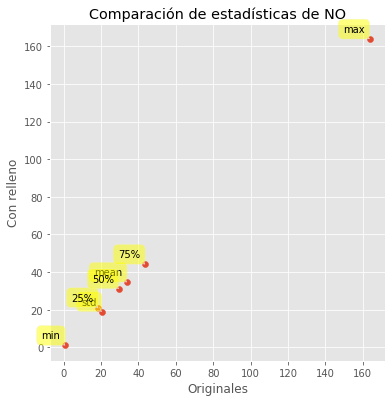

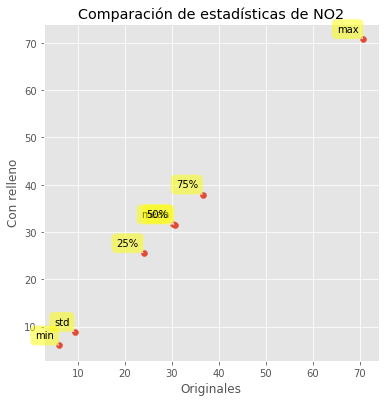

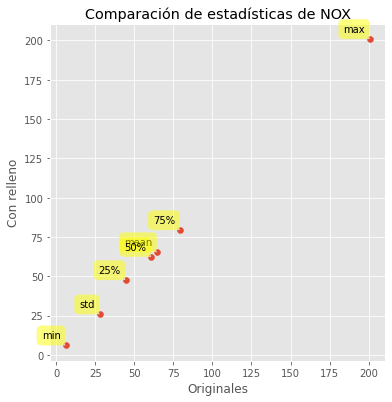

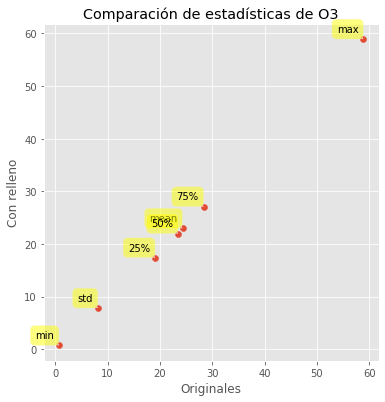

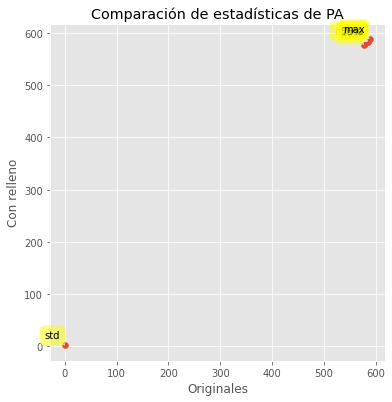

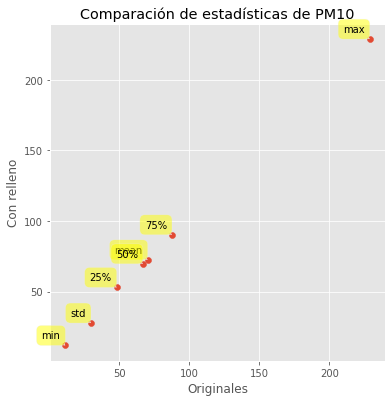

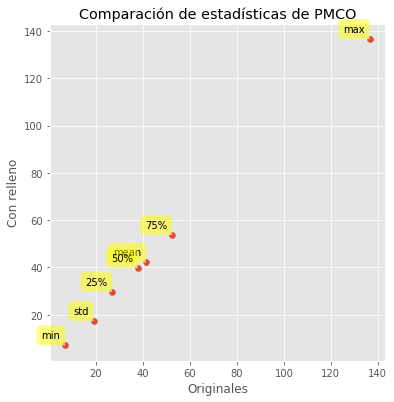

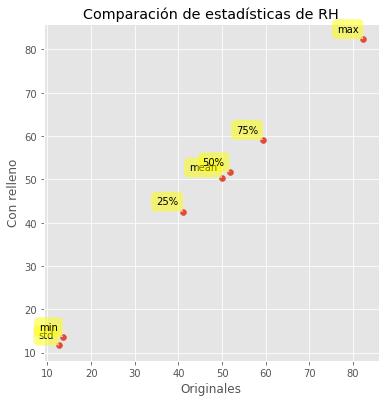

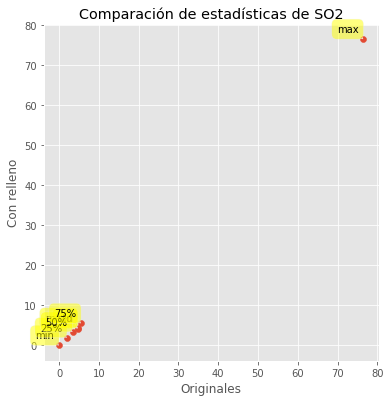

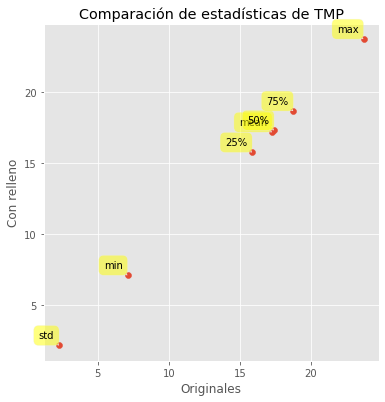

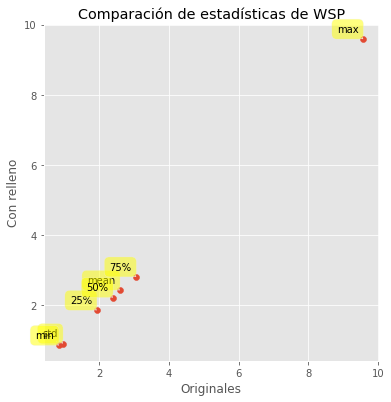

In [ ]:
#verifica rango de datos originales y con relleno
orig=df_d.describe()
rell=DF.describe()

labels = orig.index[1:]

#grafica PM25
plt.subplots(figsize=(6,6))
plt.subplots_adjust(bottom = 0.1)
plt.scatter(x=orig['PM2.5'][1:], y=rell['y'][1:], marker='o',
       cmap=plt.get_cmap('Spectral'))
for label, x, y in zip(labels, orig['PM2.5'][1:], rell['y'][1:]):
  plt.annotate(label,xy=(x, y),xytext=(-5, 5),
  textcoords='offset points', ha='right', va='bottom',
  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
  arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.xlabel('Originales')
plt.ylabel('Con relleno')
plt.title('Comparación de estadísticas de PM2.5')
plt.show()

#grafica los regresores
for p in orig.columns[1:]:
  plt.subplots(figsize=(6,6))
  plt.subplots_adjust(bottom = 0.1)
  plt.scatter(x=orig[p][1:], y=rell[p][1:], marker='o',
        cmap=plt.get_cmap('Spectral'))
  for label, x, y in zip(labels, orig[p][1:], rell[p][1:]):
    plt.annotate(label,xy=(x, y),xytext=(-5, 5),
    textcoords='offset points', ha='right', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
    arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
  plt.xlabel('Originales')
  plt.ylabel('Con relleno')
  plt.title('Comparación de estadísticas de '+p)
  plt.show()

del orig
del rell

Comparación entre los datos originales y los datos con relleno


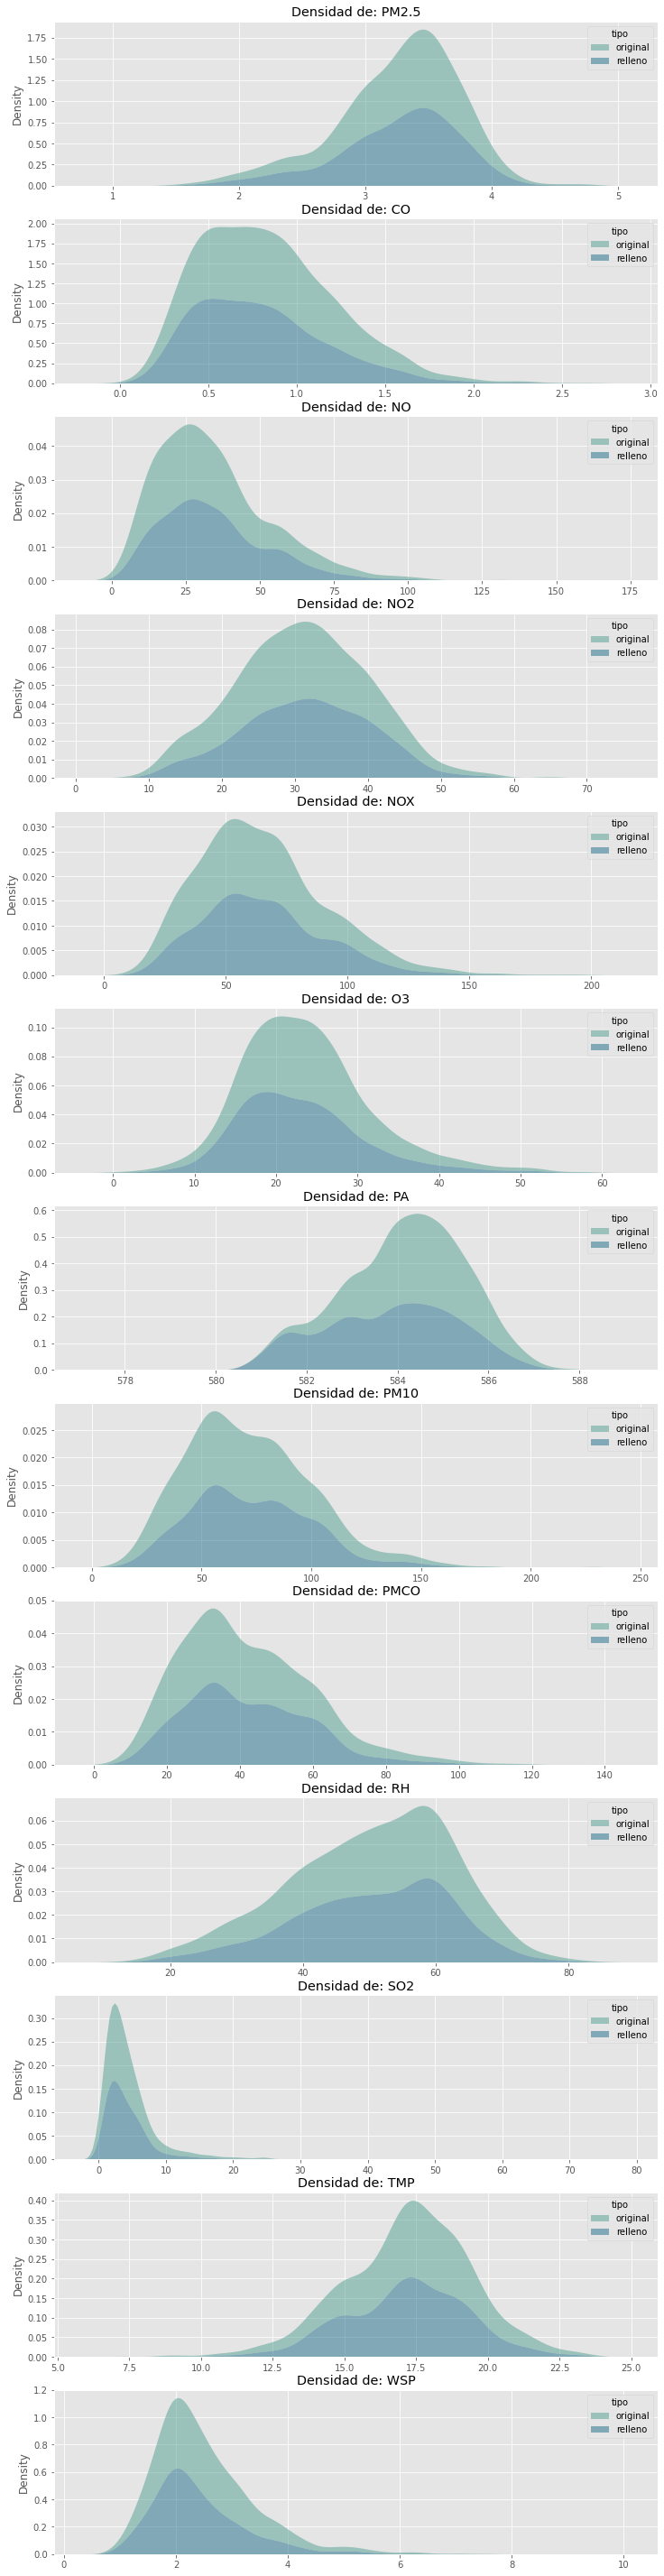

In [ ]:
#Un vistazo por los promedios diarios sin faltantes
#las escalas de los datos son muy variadas, por lo que se recomienda escalar
orig=df_d.copy()
orig=orig.reset_index()
rell=DF.copy()
orig.drop(columns=['date2'],inplace=True,axis=1)
rell.drop(columns=['ds'],inplace=True,axis=1)
rell.columns=orig.columns
orig['tipo']='original'
rell['tipo']='relleno'
ambos=pd.concat([orig,rell])
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)

print("Comparación entre los datos originales y los datos con relleno")
for i, cn in enumerate(ambos):
    if cn!='tipo':
      ax = plt.subplot(gs[i])    
      kdeplot(data=ambos, x=cn, hue="tipo", multiple="stack",fill=True,
              common_norm=False, palette="crest",alpha=.5,linewidth=0)
      ax.set_xlabel('')
      ax.set_title('Densidad de: ' + str(cn))
    
plt.show()

del orig
del rell
del ambos

#https://seaborn.pydata.org/generated/seaborn.kdeplot.html
#https://towardsdatascience.com/data-pre-processing-techniques-you-should-know-8954662716d6

In [ ]:
#Verifica el total de faltantes para usar el modelo
pd.DataFrame(pd.concat([DF.isnull().sum(),DF0_o.isnull().sum()],axis=1))

0    1
ds      0  0.0
y     717  NaN
CO      0  0.0
NO      0  0.0
NO2     0  0.0
NOX     0  0.0
O3      0  0.0
PA      0  0.0
PM10    0  0.0
PMCO    0  0.0
RH      0  0.0
SO2     0  0.0
TMP     0  0.0
WSP     0  0.0

In [ ]:
#Otro vistazo por los promedios diarios sin faltantes
#las escalas de los datos son muy variadas, por lo que se recomienda escalar
# DF_rev=DF.copy()
# DF_rev.drop(columns=['ds'],inplace=True,axis=1)

# plt.figure(figsize=(12,28*4))
# gs = gridspec.GridSpec(28, 1)
# for i, cn in enumerate(DF_rev):
#     ax = plt.subplot(gs[i])
#     sns.distplot(DF_rev[cn], bins=50)
#     ax.set_xlabel('')
#     ax.set_title('histogram of feature: ' + str(cn))
# plt.show()

# del DF_rev


In [ ]:
#help(Prophet.add_regressor)

In [ ]:
#Define el periodo de aprendizaje y el de prueba (4años-1año) para los datos con los regresores
train_o=DF[(DF['ds'] >= '2015-01-01') & (DF['ds'] <= '2018-12-31')]
test_o=DF[(DF['ds'] > '2018-12-31') & (DF['ds'] <= '2020-09-30')]
print("Total de datos en el conjunto de entrenamiento: ",train_o.shape[0])
print("Total de datos en el conjunto de prueba: ",test_o.shape[0])
print("Porcentaje de datos en el conjunto de entrenamiento: ",round(100*train_o.shape[0]/DF[DF['ds'] <= '2020-09-30'].shape[0],0))
print("Porcentaje de datos en el conjunto de prueba: ",round(100*test_o.shape[0]/DF[DF['ds'] <= '2020-09-30'].shape[0],0))
print("Regresores en el conjunto de entrenamiento:")
print(train_o.count())
print("Regresores en el conjunto de prueba:")
print(test_o.count())

Total de datos en el conjunto de entrenamiento:  1461
Total de datos en el conjunto de prueba:  639
Porcentaje de datos en el conjunto de entrenamiento:  70.0
Porcentaje de datos en el conjunto de prueba:  30.0
Regresores en el conjunto de entrenamiento:
ds      1461
y       1256
CO      1461
NO      1461
NO2     1461
NOX     1461
O3      1461
PA      1461
PM10    1461
PMCO    1461
RH      1461
SO2     1461
TMP     1461
WSP     1461
dtype: int64
Regresores en el conjunto de prueba:
ds      639
y       250
CO      639
NO      639
NO2     639
NOX     639
O3      639
PA      639
PM10    639
PMCO    639
RH      639
SO2     639
TMP     639
WSP     639
dtype: int64


In [ ]:
#Relación de renglones por tipo de archivo train/test/future
print("Filas en df_d + fechas de pronostico",df_d.shape[0]+489)
print("Filas en DF",DF.shape[0])
print("Filas en train y test",train_o.shape[0]+test_o.shape[0])
print("Filas en future",DF.shape[0]-(train_o.shape[0]+test_o.shape[0]))
print("")
ds_train=train_o.ds
ds_resto=DF.ds[~DF.ds.isin(train_o.ds)]
ds_test=ds_resto[ds_resto.isin(test_o.ds)]
ds_future=ds_resto[~ds_resto.isin(test_o.ds)]
print("Rango de fechas del conjunto de entrenamiento:")
print([ds_train.min(),ds_train.max()])
print("Rango de fechas del conjunto de prueba:")
print([ds_test.min(),ds_test.max()])
print("Rango de fechas del conjunto de pronóstico:")
print([ds_future.min(),ds_future.max()])
print("")
print("Fechas finales:")
print("Entrenamiento")
print(ds_train.tail()) #del 2015/01/01 al 2019/07/31 son 1673 filas
print("Prueba")
print(ds_test.tail()) #del 2019/08/01  al 2020/09/30 son 427 filas
print("Pronóstico")
print(ds_future.tail()) #del 2020/10/01  al 2021/01/31 son 123 filas

Filas en df_d + fechas de pronostico 2223
Filas en DF 2223
Filas en train y test 2100
Filas en future 123

Rango de fechas del conjunto de entrenamiento:
[Timestamp('2015-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00')]
Rango de fechas del conjunto de prueba:
[Timestamp('2019-01-01 00:00:00'), Timestamp('2020-09-30 00:00:00')]
Rango de fechas del conjunto de pronóstico:
[Timestamp('2020-10-01 00:00:00'), Timestamp('2021-01-31 00:00:00')]

Fechas finales:
Entrenamiento
1456   2018-12-27
1457   2018-12-28
1458   2018-12-29
1459   2018-12-30
1460   2018-12-31
Name: ds, dtype: datetime64[ns]
Prueba
2095   2020-09-26
2096   2020-09-27
2097   2020-09-28
2098   2020-09-29
2099   2020-09-30
Name: ds, dtype: datetime64[ns]
Pronóstico
2218   2021-01-27
2219   2021-01-28
2220   2021-01-29
2221   2021-01-30
2222   2021-01-31
Name: ds, dtype: datetime64[ns]


In [ ]:
# Crea funcion para estandarizar datos

class MyScaler(TransformerMixin, BaseEstimator):            #función para estandarizar #https://stackoverflow.com/questions/59434397/standardscaler-valueerror-operands-could-not-be-broadcast-together-with-shapes
    def fit(self, X, y=None):
        self.means_ = X.mean(axis=0)
        self.std_dev_ = X.std(axis=0)
        return self
    def transform(self, X, y=None):
        return (X - self.means_[:X.shape[1]]) / self.std_dev_[:X.shape[1]]


El proceso de normalizar los datos se hará para cada conjunto de datos por separado (train,test)

Comparación entre los datos estandarizados (boxplot)


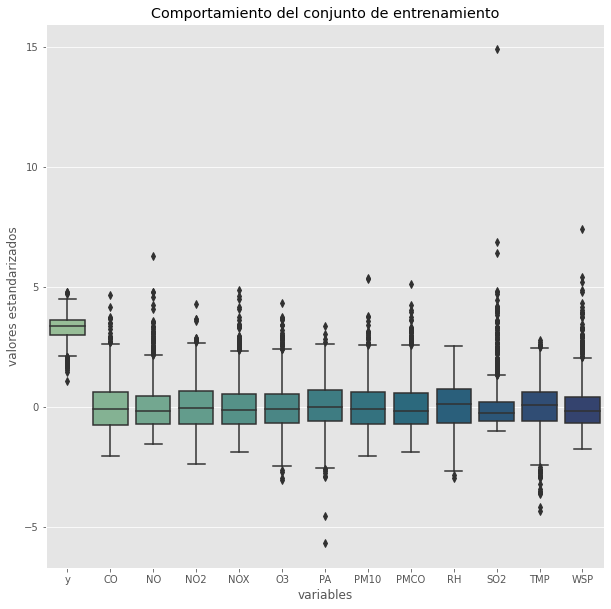

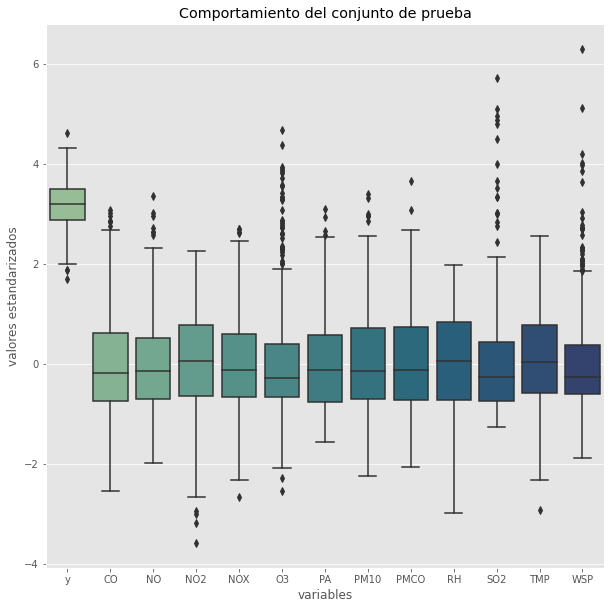

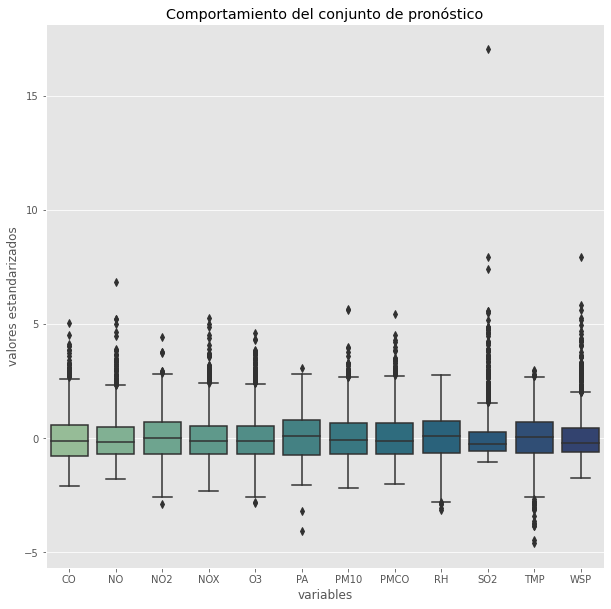

In [ ]:
#El proceso de normalizar los datos se hará para cada conjunto de datos por separado (train,test,future) sin modificar y

train=train_o.copy()
test=test_o.copy()
DF0=DF0_o.copy()

scaler = MyScaler()                                               #función para estandarizar

#estandarización
train.iloc[:,2:]=scaler.fit_transform(train.iloc[:,2:])           #no se transforma 'ds' ni 'y'
test.iloc[:,2:]=scaler.fit_transform(test.iloc[:,2:])             #no se transforma 'ds' ni 'y'
DF0.iloc[:,1:]=scaler.fit_transform(DF0.iloc[:,1:])               #no se transforma 'ds'


train_bp=pd.melt(train, id_vars=['ds'], value_vars=train.columns[~train.columns.isin(['ds'])])
test_bp=pd.melt(test, id_vars=['ds'], value_vars=test.columns[~test.columns.isin(['ds'])])
DF0_bp=pd.melt(DF0, id_vars=['ds'], value_vars=DF0.columns[~DF0.columns.isin(['ds'])])

print("Comparación entre los datos estandarizados (boxplot)")
plt.figure(figsize=(10,10))
ax=sns.boxplot(x='variable',y='value', data=train_bp, palette="crest")
ax.set(xlabel="variables", ylabel="valores estandarizados", title='Comportamiento del conjunto de entrenamiento')
plt.show()

plt.figure(figsize=(10,10))
ax=sns.boxplot(x='variable',y='value', data=test_bp, palette="crest")
ax.set(xlabel="variables", ylabel="valores estandarizados", title='Comportamiento del conjunto de prueba')
plt.show()


plt.figure(figsize=(10,10))
ax=sns.boxplot(x='variable',y='value', data=DF0_bp, palette="crest")
ax.set(xlabel="variables", ylabel="valores estandarizados", title='Comportamiento del conjunto de pronóstico')
plt.show()

del train_bp
del test_bp
del DF0_bp
#https://stackoverflow.com/questions/59434397/standardscaler-valueerror-operands-could-not-be-broadcast-together-with-shapes
#https://medium.com/datadriveninvestor/data-preprocessing-for-machine-learning-188e9eef1d2c


Pronóstico de log(PM2.5) al 31/01/2021 univariado


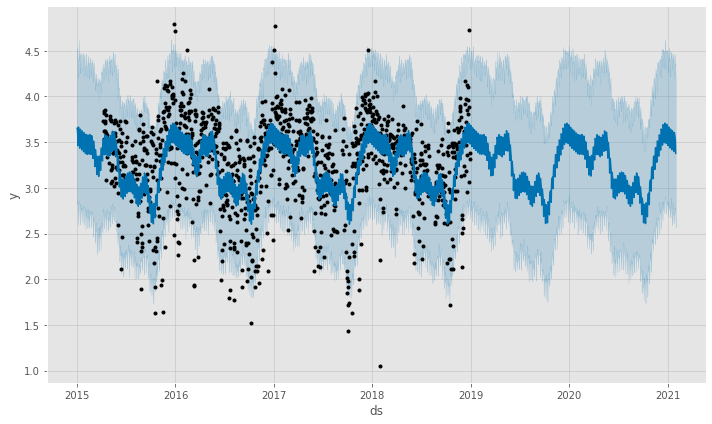

In [ ]:
#Modelo PM2.5 univariado
m_unv=Prophet(interval_width=0.95,yearly_seasonality=True,
              weekly_seasonality=True,daily_seasonality=False,growth='flat') #define la estructura del modelo

m_unv.fit(train_o[['ds','y']])                              #ajusta el modelo
forecast_unv=m_unv.predict(DF0_o[['ds']])                     #predicción
print("Pronóstico de log(PM2.5) al "+ pronostico +" univariado")
fig0 = m_unv.plot(forecast_unv)


In [ ]:
#estimador e intervalo de confianza para el modelo univariado
np.exp(forecast_unv[['yhat','yhat_lower','yhat_upper']]).head(3)
#forecast_unv[['yhat','yhat_lower','yhat_upper']].head(3)
#forecast_unv[['yhat','yhat_lower','yhat_upper']].max()

yhat  yhat_lower  yhat_upper
0  38.501886   16.823107   92.495360
1  37.921269   17.486073   85.439006
2  36.171899   15.376233   77.268405

In [ ]:
#DataFrame para los resultados de las métricas de todos los modelos
metricas=pd.DataFrame({'MSE': [0], 'RMSE': [0], 'MAE': [0], 'MAPE': [0], 'MDAPE': [0], 'Coverage': [0]},
                      index=['Univariado','Días festivos','Regresores','Valores de Cambio','Hiperparámetros'])
metricas=metricas.T


In [ ]:
#Validación cruzada para el modelo univariado

df_cv_unv = cross_validation(m_unv, initial='1200 days', period='100 days', horizon = '100 days')

#Evaluar las métricas

df_m_unv = performance_metrics(df_cv_unv)
metricas.iloc[:,0]=list(df_m_unv.mean()[1:])

metricas

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-09-22 00:00:00 and 2018-09-22 00:00:00


Univariado  Días festivos  ...  Valores de Cambio  Hiperparámetros
MSE         0.260549              0  ...                  0                0
RMSE        0.477107              0  ...                  0                0
MAE         0.409945              0  ...                  0                0
MAPE        0.136996              0  ...                  0                0
MDAPE       0.119520              0  ...                  0                0
Coverage    0.895503              0  ...                  0                0

[6 rows x 5 columns]

Pronóstico de log(PM2.5) al 31/01/2021 con días festivos


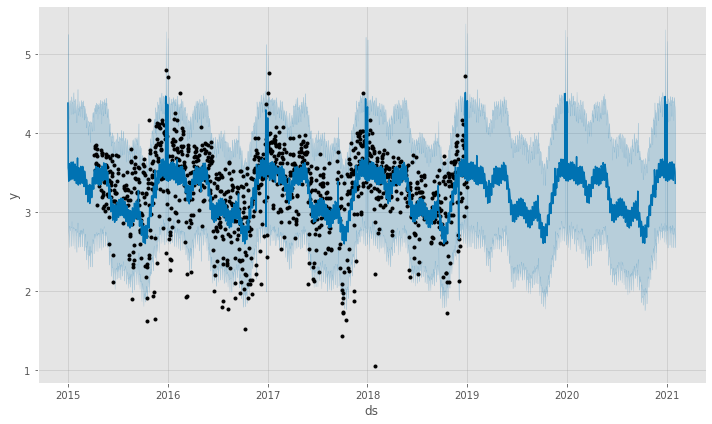

In [ ]:
#Modelo PM2.5 univariado y días festivos
m_fes=Prophet(interval_width=0.95,yearly_seasonality=True,
              weekly_seasonality=True,daily_seasonality=False,growth='flat') #define la estructura del modelo
  
m_fes.add_country_holidays(country_name='MX')             #agrega los días festivos
m_fes.fit(train_o[['ds','y']])                              #ajusta el modelo
forecast_fes=m_fes.predict(DF0_o[['ds']])                     #predicción

print("Pronóstico de log(PM2.5) al "+ pronostico +" con días festivos")
fig0 = m_fes.plot(forecast_fes)


In [ ]:
#estimador e intervalo de confianza para el modelo con días festivos
np.exp(forecast_fes[['yhat','yhat_lower','yhat_upper']]).head(3)

yhat  yhat_lower  yhat_upper
0  80.043996   37.480892  191.983449
1  35.199463   15.839980   78.746869
2  34.094827   15.039175   77.354476

In [ ]:
#Validación cruzada para el modelo de días festivos

df_cv_fes = cross_validation(m_fes, initial='1200 days', period='100 days', horizon = '100 days')

#Evaluar las métricas

df_m_fes = performance_metrics(df_cv_fes)
metricas.iloc[:,1]=list(df_m_fes.mean()[1:])

metricas

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-09-22 00:00:00 and 2018-09-22 00:00:00


Univariado  Días festivos  ...  Valores de Cambio  Hiperparámetros
MSE         0.260549       0.260089  ...                  0                0
RMSE        0.477107       0.476849  ...                  0                0
MAE         0.409945       0.408811  ...                  0                0
MAPE        0.136996       0.137024  ...                  0                0
MDAPE       0.119520       0.118734  ...                  0                0
Coverage    0.895503       0.904762  ...                  0                0

[6 rows x 5 columns]

In [ ]:
#Eliminar PM10, PMCO, NO, NO2 por la dependencia entre ellas
param0=list(param)
param0.pop(7)
param0.pop(7)
param0.pop(2)
param0.pop(2)
param0


['PM2.5', 'CO', 'NOX', 'O3', 'PA', 'RH', 'SO2', 'TMP', 'WSP']

Pronóstico de PM2.5 al 31/01/2021 con regresores y días festivos


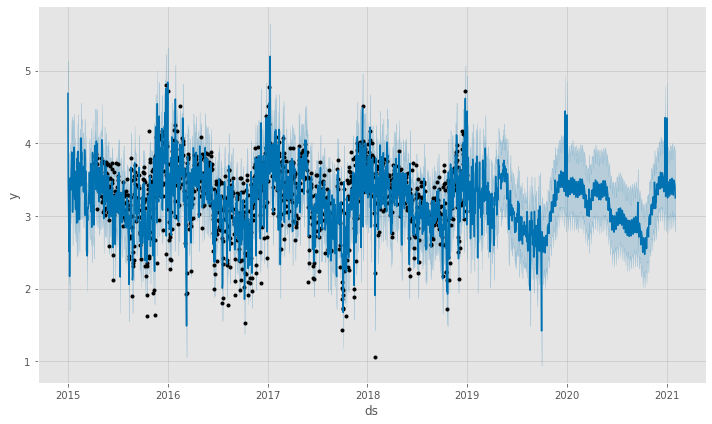

In [ ]:
#Modelo PM2.5 vs días festivos y regresores
m_reg=Prophet(interval_width=0.95,yearly_seasonality=True,
              weekly_seasonality=True,daily_seasonality=False,growth='flat') #define la estructura del modelo
for p in param0[1:]:
  m_reg.add_regressor(p,standardize=True)   #agrega los regresores
  
m_reg.add_country_holidays(country_name='MX') #agrega los días festivos
m_reg.fit(train_o)                              #ajusta el modelo
forecast_reg=m_reg.predict(DF0_o)               #predicción

print("Pronóstico de PM2.5 al "+ pronostico +" con regresores y días festivos")
fig1 = m_reg.plot(forecast_reg)

#https://futurice.com/blog/business-forecasting-with-facebook-prophet

In [ ]:
#estimador e intervalo de confianza para el modelo con días festivos y regresores
np.exp(forecast_reg[['yhat','yhat_lower','yhat_upper']]).max()
#forecast_reg[['yhat','yhat_lower','yhat_upper']].max()
# x=np.exp(forecast_reg['yhat'])
# maxx=forecast_reg.iloc[736,6:102].max()
# forecast_reg.iloc[736][forecast_reg.iloc[736]==maxx]


yhat          180.550853
yhat_lower    110.894806
yhat_upper    283.294988
dtype: float64

In [ ]:
#Validación cruzada para el modelo de días festivos y regresores

df_cv_reg = cross_validation(m_reg, initial='1200 days', period='100 days', horizon = '100 days')

#Evaluar las métricas

df_m_reg = performance_metrics(df_cv_reg)
metricas.iloc[:,2]=list(df_m_reg.mean()[1:])

metricas

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-09-22 00:00:00 and 2018-09-22 00:00:00


Univariado  Días festivos  ...  Valores de Cambio  Hiperparámetros
MSE         0.260549       0.260089  ...           0.061898                0
RMSE        0.477107       0.476849  ...           0.239131                0
MAE         0.409945       0.408811  ...           0.190821                0
MAPE        0.136996       0.137024  ...           0.061431                0
MDAPE       0.119520       0.118734  ...           0.052135                0
Coverage    0.895503       0.904762  ...           0.914021                0

[6 rows x 5 columns]

In [ ]:
#Un vistazo a la descomposición de la serie OPCION 1
#fig = m_reg.plot_components(forecast_reg)

In [ ]:
#Un vistazo a la descomposición de la serie OPCION 2

plot_components_plotly(m_reg, forecast_reg)

Pronóstico de log(PM2.5) al 31/01/2021 con regresores, días festivos y puntos de cambio


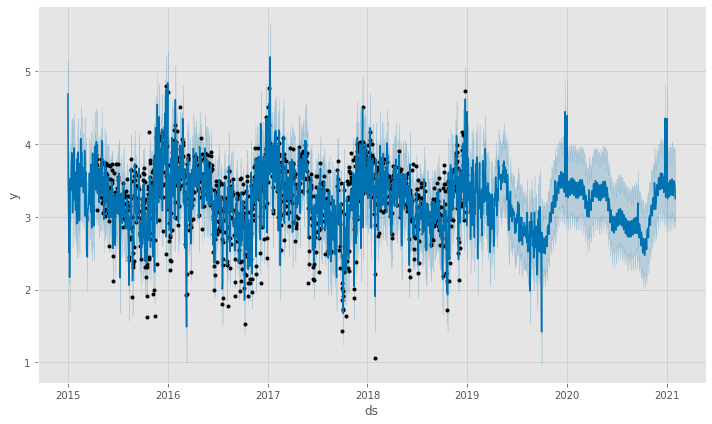

In [ ]:
#Modelo PM2.5 vs regresores y puntos de cambio (changepoint)
#no representa un plus pues la tendencia es casi cero
m_reg_chp=Prophet(interval_width=0.95,yearly_seasonality=True,weekly_seasonality=True,
                  daily_seasonality=False,growth='flat',changepoint_prior_scale=0.001) #define la estructura del modelo
for p in param0[1:]:
  m_reg_chp.add_regressor(p,standardize='auto')    #agrega los regresores

m_reg_chp.add_country_holidays(country_name='MX')  #agrega los días festivos
m_reg_chp.fit(train_o)                               #ajusta el modelo
forecast_reg_chp=m_reg_chp.predict(DF0_o)          #predicción

print("Pronóstico de log(PM2.5) al "+ pronostico +" con regresores, días festivos y puntos de cambio")
fig2 = m_reg_chp.plot(forecast_reg_chp)

In [ ]:
#estimador e intervalo de confianza para el modelo con días festivos, regresores y puntos de cambio
np.exp(forecast_reg_chp[['yhat','yhat_lower','yhat_upper']]).max()

yhat          180.550853
yhat_lower    114.414162
yhat_upper    285.381380
dtype: float64

In [ ]:
#Validación cruzada para el modelo de días festivos, regresores y puntos de cambio

df_cv_reg_chp = cross_validation(m_reg_chp, initial='1200 days', period='100 days', horizon = '100 days')

#Evaluar las métricas

df_m_reg_chp = performance_metrics(df_cv_reg_chp)
metricas.iloc[:,3]=list(df_m_reg_chp.mean()[1:])

metricas

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-09-22 00:00:00 and 2018-09-22 00:00:00


Univariado  Días festivos  ...  Valores de Cambio  Hiperparámetros
MSE         0.260549       0.260089  ...           0.070766                0
RMSE        0.477107       0.476849  ...           0.252982                0
MAE         0.409945       0.408811  ...           0.204132                0
MAPE        0.136996       0.137024  ...           0.065605                0
MDAPE       0.119520       0.118734  ...           0.055478                0
Coverage    0.895503       0.904762  ...           0.902116                0

[6 rows x 5 columns]

In [ ]:
#Un vistazo a la descomposición de la serie

plot_components_plotly(m_reg_chp, forecast_reg_chp)

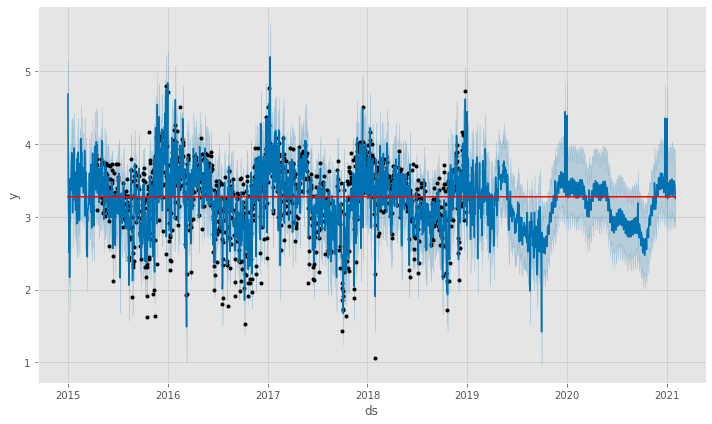

In [ ]:
#Un viztazo a los changepoints
#No muestran impacto en la serie
fig = m_reg.plot(forecast_reg_chp)
a = add_changepoints_to_plot(fig.gca(), m_reg_chp, forecast_reg_chp)

In [ ]:
#Guardar los modelos con regresores y con puntos de cambio


with open(ruta+'m_reg_'+estac+'.json', 'w') as fout:
    json.dump(model_to_json(m_reg), fout)  # Save model

with open(ruta+'m_reg_chp_'+estac+'.json', 'w') as fout:
    json.dump(model_to_json(m_reg_chp), fout)  # Save model


#with open('m_reg_MER.json', 'r') as fin:
#    m_reg_MER = model_from_json(json.load(fin))  # Load model

#with open('m_reg_chp_MER.json', 'r') as fin:
#    m_reg_chp_MER = model_from_json(json.load(fin))  # Load model

In [ ]:
#help(fbprophet.diagnostics)

In [ ]:
#Buscar los mejores Hiperparametros del modelo

from datetime import datetime
# datetime object containing current date and time
before = datetime.now()

#definición de la malla de los hiperparametros
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'interval_width':[0.95], 
    'changepoint_range' : [0.9],
    'yearly_seasonality':[True], 
    
}

# Generación de todas las combinaciones de hiperparámetros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

rmses = []  #Lista para guardar RMSE para cada combinación de hiperparámetros

# Evaluación de los hiperparámetros por medio de validación cruzada
for params in all_params: 
    m_cv = Prophet(**params)                      #agrega los hiperparámetros
    m_cv.add_country_holidays(country_name='MX')  #agrega los días festivos
    for p in param0[1:]:
      m_cv.add_regressor(p,standardize='auto')    #agrega los regresores

    m_cv.fit(train_o)                               #ajusta el modelo
    df_cv = cross_validation(m_cv,initial='1200 days',
                             period='100 days',horizon='100 days',
                             parallel="processes") #realiza la validación cruzada
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

# Select best parameters
best_params = all_params[np.argmin(rmses)]
print(best_params)
now = datetime.now()
print(now-before)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-09-22 00:00:00 and 2018-09-22 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47e5fdccc0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-09-22 00:00:00 and 2018-09-22 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47e7e26e10>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-09-22 00:00:00 and 2018-09-22 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47e57cfe80>
INFO:fbprophet:Disabling daily seasonality. Run prop

    changepoint_prior_scale  ...      rmse
0                     0.001  ...  0.267415
1                     0.001  ...  0.257059
2                     0.001  ...  0.263079
3                     0.001  ...  0.261762
4                     0.001  ...  0.267424
..                      ...  ...       ...
59                    0.500  ...  0.272411
60                    0.500  ...  0.274021
61                    0.500  ...  0.272897
62                    0.500  ...  0.278653
63                    0.500  ...  0.274082

[64 rows x 7 columns]
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'interval_width': 0.95, 'changepoint_range': 0.9, 'yearly_seasonality': True}
0:04:42.546551


In [ ]:
best_params

{'changepoint_prior_scale': 0.001,
 'changepoint_range': 0.9,
 'holidays_prior_scale': 1.0,
 'interval_width': 0.95,
 'seasonality_prior_scale': 0.1,
 'yearly_seasonality': True}

In [ ]:
bp=list(best_params.values())
bp
#['changepoint_prior_scale','seasonality_prior_scale','holidays_prior_scale',
#'interval_width','changepoint_range','yearly_seasonality']

[0.001, 0.1, 1.0, 0.95, 0.9, True]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


0:12:35.339339


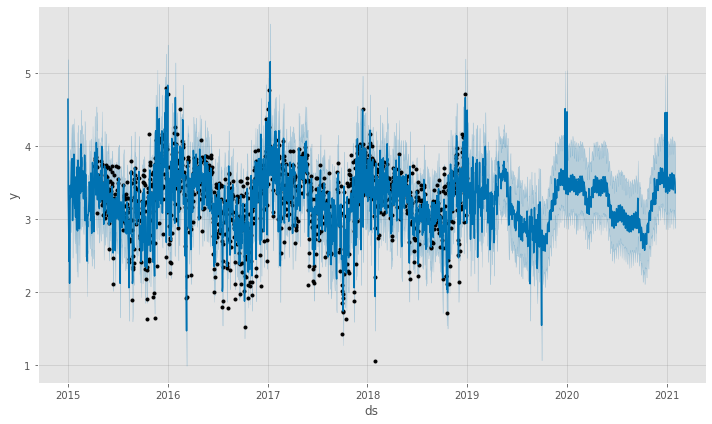

In [ ]:
before=datetime.now()

m_bp = Prophet(mcmc_samples=300, 
          changepoint_prior_scale=bp[0],seasonality_prior_scale=bp[1],holidays_prior_scale=bp[2],interval_width=bp[3],changepoint_range=bp[4], 
          yearly_seasonality=bp[5],weekly_seasonality=True,daily_seasonality=False)

for p in param0[1:]:
  m_bp.add_regressor(p,standardize='auto')     #agrega regresores

m_bp.add_country_holidays(country_name='MX') #agrega días festivos
forecast_bp = m_bp.fit(train_o).predict(DF0_o)   #ajusta el modelo
fig3 = m_bp.plot(forecast_bp)

now = datetime.now()
print(now-before)
#otra manera de ver la misma gráfica
#pd.concat([DF.set_index('ds')['y'],forecast_bp.set_index('ds')['yhat']],axis=1).plot(figsize=(16,8))

In [ ]:
#estimador e intervalo de confianza para el modelo con días festivos, regresores y puntos de cambio
np.exp(forecast_bp[['yhat','yhat_lower','yhat_upper']]).max()

yhat          173.991703
yhat_lower    103.367363
yhat_upper    293.681372
dtype: float64

In [ ]:
#Validación cruzada para el modelo de hiperparámetros
before=datetime.now()
df_cv_bp = cross_validation(m_bp, initial='1200 days', period='100 days', horizon = '100 days')

#Evaluar las métricas

df_m_bp = performance_metrics(df_cv_bp)
metricas.iloc[:,4]=list(df_m_bp.mean()[1:])

metricas
now=datetime.now()
print(now-before)

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-09-22 00:00:00 and 2018-09-22 00:00:00


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Univariado  Días festivos  ...  Valores de Cambio  Hiperparámetros
MSE         0.260549       0.260089  ...           0.070766         0.188870
RMSE        0.477107       0.476849  ...           0.252982         0.331586
MAE         0.409945       0.408811  ...           0.204132         0.237674
MAPE        0.136996       0.137024  ...           0.065605         0.079745
MDAPE       0.119520       0.118734  ...           0.055478         0.057421
Coverage    0.895503       0.904762  ...           0.902116         0.925926

[6 rows x 5 columns]

In [ ]:
#Guarda el modelo
with open(ruta + 'm_bp_'+estac+'.json', 'w') as fout:
    json.dump(model_to_json(m_bp), fout)  # Save model


#with open('m_bp_MER.json', 'r') as fin:
#    m_bp = model_from_json(json.load(fin))  # Load model


In [ ]:
#Un vistazo a la descomposición de la serie
plot_components_plotly(m_bp, forecast_bp)

<Figure size 720x720 with 0 Axes>

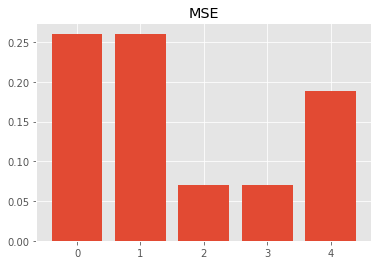

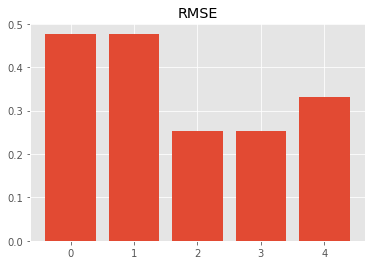

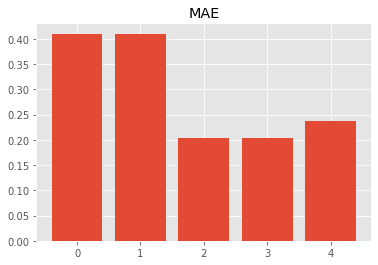

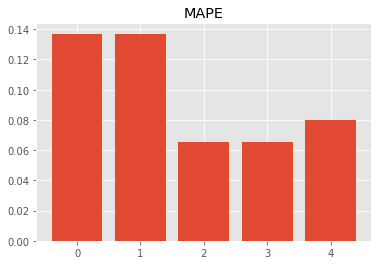

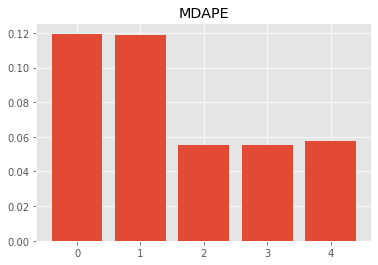

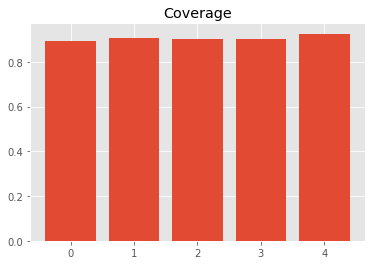

In [ ]:
#Comparar metricas

plt.figure(figsize=(10,10))
for m in metricas.index:
  fig, ax = plt.subplots()
  ax.bar(np.arange(len(metricas.columns)),metricas.loc[m,:])
  plt.title(m)
  plt.show()
  


  #plt.plot(np.arange(len(metricas.columns)),metricas.loc[m,:])
  #plt.xlabel('Métricas')
  #plt.ylabel()
  


In [ ]:
#Define funciones para visualizar entrenamiento, prueba y pronóstico juntos

def make_verif(forecast, data_train, data_test): 
    """
    put together the forecast (coming from fbprophet) 
    and the overved data, and set the index to be a proper datetime index, 
    for plotting    
    """
    dat=pd.DataFrame(pd.to_datetime(forecast.ds, format="%Y-%m-%d"))
    dat=dat.set_index('ds')
    if type(forecast.index)!=type(dat.index):
      forecast.index = pd.to_datetime(forecast.ds, format="%Y-%m-%d")

    dat=pd.DataFrame(pd.to_datetime(train.ds, format="%Y-%m-%d"))
    dat=dat.set_index('ds')
    if type(train.index)!=type(dat.index):
      data_train.index = pd.to_datetime(data_train.ds, format="%Y-%m-%d")

    dat=pd.DataFrame(pd.to_datetime(test.ds, format="%Y-%m-%d"))
    dat=dat.set_index('ds')
    if type(test.index)!=type(dat.index):
      data_test.index = pd.to_datetime(data_test.ds, format="%Y-%m-%d")
      
    data = pd.concat([data_train, data_test], axis=0)                       #une verticalmente train test    
    forecast.loc[:,'y'] = data.loc[:,'y']                                    #agrega 'y' 
    
    return forecast

In [ ]:
def plot_verif(verif, year=2019):
    """
    plots the forecasts and observed data, the year parameters is used to indicate 
    the division between the training and test sets 
    """
    
    f, ax = plt.subplots(figsize=(10, 8))
    
    train = verif.loc[:str(year - 1),:]                                                         #train
    
    ax.plot(train.index, train.y, 'ko', markersize=3)
    
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]                                                              #test
    
    ax.plot(test.index, test.y, 'ro', markersize=3)
    
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    
    ax.axvline(str(year), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)
    
    return f


log(PM2.5)


ConversionError: ignored

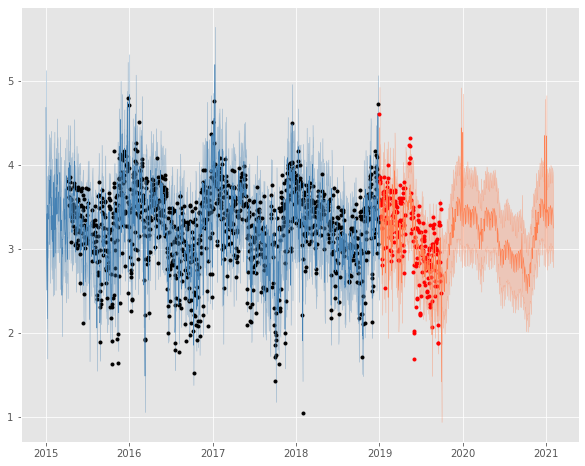

In [ ]:
#Visualización con el modelo de menor error

verificador=make_verif(forecast_reg, train, test)
print("log(PM2.5)")
plot_verif(verificador, year=2019)


PM2.5


ConversionError: ignored

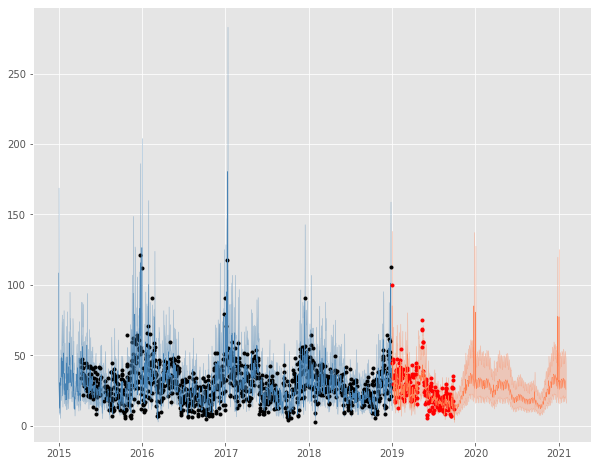

In [ ]:
#transforma log(PM2.5)
verificador[['y','yhat','yhat_lower','yhat_upper']]=np.exp(verificador[['y','yhat','yhat_lower','yhat_upper']])
print("PM2.5")
plot_verif(verificador, year=2019)

In [ ]:
#Comparativo de metricas
metricas

Univariado  Días festivos  ...  Valores de Cambio  Hiperparámetros
MSE         0.260549       0.260089  ...           0.070766         0.188870
RMSE        0.477107       0.476849  ...           0.252982         0.331586
MAE         0.409945       0.408811  ...           0.204132         0.237674
MAPE        0.136996       0.137024  ...           0.065605         0.079745
MDAPE       0.119520       0.118734  ...           0.055478         0.057421
Coverage    0.895503       0.904762  ...           0.902116         0.925926

[6 rows x 5 columns]

In [ ]:
# Colores asociados a los intervalos de calidad del aire por PM2.5 (Indice AireySalud)
#Verde Buena Bajo 25
#Amarillo Aceptable Moderado >25 y 45
#Naranja Mala Alto >45 y 79
#Rojo Muy Mala Muy Alto >79 y 147
#Morado Extremadamente Mala Extremadamente Alto >147
#25-45-79-147

#Guias de la OMS
# PM2.5: 10 µg/m3, promedio anual (de promedios diarios)
#         25 µg/m3 promedio de 24 horas


def intervalos(x,y):  
  maxx=y.max()
  fig = plt.figure(facecolor='w', figsize=(15, 10))
  ax = fig.add_subplot(111)
  ax.plot(x, y, color='black',alpha=0.7)
  ax.text(x=pd.to_datetime('2019-09-01'),y=24, s="OMS:24h (25µg/m³)", color='black',fontsize=16, fontweight='bold', alpha=0.8)
  colores={'#FFFF00':0,'#00e400':25,'#ff7e00':45,'#ff0000':79,'#8f3f97':147}
  color=list(colores.values())
  color.append(200)
  colorres=colores

  if maxx < 45:
    del colorres['#8f3f97']
    del colorres['#ff0000']
    del colorres['#ff7e00']
  elif maxx < 79:
    del colorres['#8f3f97']
    del colorres['#ff0000']    
  elif maxx< 147:
    del colorres['#8f3f97']
  else:
    colorres=colores
  print(colorres)

  p=0
  for j, k in colorres.items():
    p=p+1
    ax.fill_between(x, k, color[p] , color=j )
  
plt.show()


{'#FFFF00': 0, '#00e400': 25}


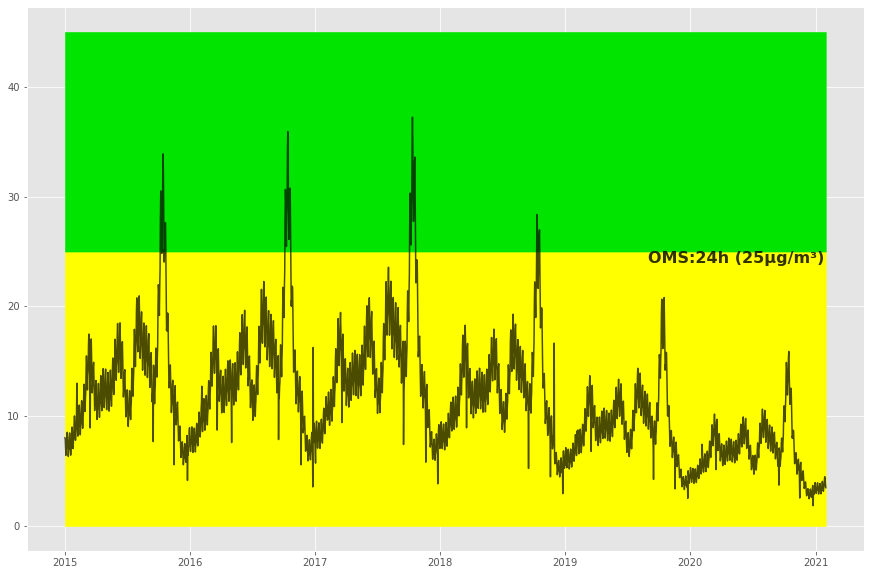

In [ ]:
#Intervalos de calidad del aire y Directrices de la OMS
intervalos(forecast['ds'], np.exp(forecast['yhat']))


# FIN ETAPA 04 MODELADO